In [9]:
import xml.etree.ElementTree as ET
import matplotlib as plt
import pandas as pd
import numpy as np
import trec
import pprint as pp
import pickle

Qrels = "qrels-clinical_trials.txt"

Queries = "topics-2014_2015-summary.topics"


with open(Queries, 'r') as queries_reader:
    txt = queries_reader.read()

root = ET.fromstring(txt)

cases = {}
for query in root.iter('TOP'):
    q_num = query.find('NUM').text
    q_title = query.find('TITLE').text
    cases[q_num] = q_title


eval = trec.TrecEvaluation(cases, Qrels)


pickle.dump(cases, open("cases.bin", "wb"))


In [6]:
import xml.etree.ElementTree as ET
import tarfile

tar = tarfile.open("clinicaltrials.gov-16_dec_2015.tgz", "r:gz")
doc_ids = []
brief_titles = []
detailed_descriptions = []
brief_summaries = []
criterias = []
genders = []
minimum_ages = []
maximum_ages = []
#iterations = 1000
#count = 0


for tarinfo in tar:
    if tarinfo.size > 500:
        txt = tar.extractfile(tarinfo).read().decode("utf-8", "strict")
        root = ET.fromstring(txt)

        judged = False
        for doc_id in root.iter('nct_id'):
            if doc_id.text in eval.judged_docs:
                judged = True
                doc_ids.append(doc_id.text.strip())

        if judged is False:
            continue

        for brief_title in root.iter('brief_title'):
            # para os brief titles nao se usa o child, o texto está direto apos <brief_title>
            brief_titles.append(brief_title.text.strip())

        for detailed_description in root.iter('detailed_description'):
            for child in detailed_description:
                # aqui, dentro do append temos que usar o child pq, se virem no documento dos clinical tirals, o texto detailed description esta dentro de um novo separadorzinho
                detailed_descriptions.append(child.text.strip())

        for brief_summary in root.iter('brief_summary'):
            for child in brief_summary:
                brief_summaries.append(child.text.strip())

        for criteria in root.iter('criteria'):
            for child in criteria:
                criterias.append(child.text.strip())

        for gender in root.iter('gender'):
            genders.append(gender.text.strip())

        for minimum_age in root.iter('minimum_age'):
            minimum_ages.append(minimum_age.text.strip())

        for maximum_age in root.iter('maximum_age'):
            maximum_ages.append(maximum_age.text.strip())

        # if(i>1000):
            # break
tar.close()


# Aqui criamos os docs pickle para cada uma das partes dos documentos
pickle.dump(doc_ids, open("doc_ids.bin", "wb"))
pickle.dump(brief_titles, open("brief_title.bin", "wb"))
pickle.dump(detailed_descriptions, open("detailed_description.bin", "wb"))
pickle.dump(brief_summaries, open("brief_summary.bin", "wb"))
pickle.dump(criterias, open("criteria.bin", "wb"))
pickle.dump(genders, open("gender.bin", "wb"))
pickle.dump(minimum_ages, open("minimum_age.bin", "wb"))
pickle.dump(maximum_ages, open("maximum_age.bin", "wb"))


Classe RetrievalModel: definimos a classe abstrata


In [2]:
import abc  # é preciso importar isto quando queremos definir uma classe abstrata


class RetrievalModel:  # vamos criar uma classe abstrata que é o molde para todas as nossas classes, cada uma um modelo
    @abc.abstractmethod  # para sabermos que RetrievalModel é uma classe abstrata e que, portanto, não pode ser instanciada, ie, "concretizada"
    def search(self):  # aqui nomeia-se uma das funcoes desta classe, neste caso, aquela onde vamos por o codigo q ordenava os docs e ainda classificava a performance do nosso modelo (junto para nao termos q mudar tanto o codigo)
        pass  # nao se pode por nada aqui na abstrata, apenas em cada classe "filho" é que se define a função, aqui apenas se nomeia


VSM Unigram


In [3]:
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.feature_extraction.text import TfidfVectorizer


class VSM(RetrievalModel):  # definimos a classe de um dos modelos e pomos o RetrievalModel para dizer q esta classe é uma subclasse da classe abstrata

    def search(self, caseid, docs):  # aqui definimos a funcao que faz tudo o q o nosso modelo fazia, pus o codigo ca dentro, pus self.doc em vez de docs
        index = TfidfVectorizer(ngram_range=(
            1, 1), analyzer='word', stop_words=None)
        index.fit(docs)
        X = index.transform(docs)
        query = cases[caseid]
        query_tfidf = index.transform([query])
        doc_scores = 1-pairwise_distances(X, query_tfidf, metric='cosine')
        scores = doc_scores.tolist()
        return scores


LMJM Unigram


In [4]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import pairwise_distances
from collections import Counter


class LMJM(RetrievalModel):
    def search(self, caseid, docs):
        index = CountVectorizer(ngram_range=(1, 1), analyzer='word')
        X = index.fit(docs)
        corpus_cv = index.transform(docs)
        all_scores = []
        lmbd = 1
        prob_word_docs = corpus_cv/np.sum(corpus_cv, axis=1)  # p(t|md)
        prob_word_corpus = np.sum(corpus_cv, axis=0) / \
            np.sum(corpus_cv)  # p(t|mc)
        log_mixture = np.log(lmbd*prob_word_docs + (1-lmbd)*prob_word_corpus)
        query = cases[caseid]
        query_cv = index.transform([query])
        total = log_mixture*query_cv.T
        return total


Chamar as classes para obtermos os valores


In [5]:
import pickle
import trec
import numpy as np

# Aqui abrimos cada documento pickle e damos-lhes os nomes para usar nas funcoes seguintes
ids = pickle.load(open("doc_ids.bin", "rb"))
brief_title = pickle.load(open("brief_title.bin", "rb"))
detailed_description = pickle.load(open("detailed_description.bin", "rb"))
brief_summary = pickle.load(open("brief_summary.bin", "rb"))
criteria = pickle.load(open("criteria.bin", "rb"))
gender = pickle.load(open("gender.bin", "rb"))
minimum_age = pickle.load(open("minimum_age.bin", "rb"))
maximum_age = pickle.load(open("maximum_age.bin", "rb"))
cases = pickle.load(open("cases.bin", "rb"))


In [6]:
#definir modelos e campos
models = [VSM()]
#, LMJM()
fields = [brief_title, detailed_description, brief_summary, criteria]

In [7]:
# separate training and test queries
print(len(cases))
cases_training = []
cases_test = []
i = 0
k = 12
for caseid in cases:
    if i <= 11:
        cases_test.append(caseid)
    else:
        cases_training.append(caseid)
    i += 1
print(len(cases_training))
print(len(cases_test))

60
48
12


In [10]:
# buscar listas
queries_training = []
docs_training = []
VSM_bt_training = []
VSM_dd_training = []
VSM_bs_training = []
VSM_cr_training = []
LMJM_bt_training = []
LMJM_dd_training = []
LMJM_bs_training = []
LMJM_cr_training = []
y_training = []

for caseid in cases_training:
    case_rel = []
    field_ind = 0
    aux = eval.relevance_judgments.loc[eval.relevance_judgments['query_id'] == int(
        caseid)]
    docs = aux['docid'].tolist()
    #print(len(docs))
    relevances = aux['rel'].tolist()
    for rel in relevances:
        if rel == 0:
            y_training.append(rel)
        elif rel == 1 or rel == 2:
            y_training.append(1)
    #print(len(relevances))
    for docid in docs:
        case_rel.append(ids.index(docid))
    #print(len(case_rel))
    for model in models:
        for field in fields:
            scores = model.search(caseid, field)
            for rel in case_rel:
                value = scores[rel] 
                if field_ind == 0:
                    queries_training.append(caseid)
                    docs_training.append(rel)
                    VSM_bt_training.append(value[0])
                elif field_ind == 1:
                    VSM_dd_training.append(value[0])
                elif field_ind == 2:
                    VSM_bs_training.append(value[0])
                elif field_ind == 3:
                    VSM_cr_training.append(value[0])
                elif field_ind == 4:
                    LMJM_bt_training.append(value[0])
                elif field_ind == 5:
                    LMJM_dd_training.append(value[0])
                elif field_ind == 6:
                    LMJM_bs_training.append(value[0])
                elif field_ind == 7:
                    LMJM_cr_training.append(value[0])
            field_ind += 1
print(len(VSM_bt_training))
print(len(VSM_dd_training))
print(len(VSM_bs_training))
print(len(VSM_cr_training))
print(len(y_training))


2920
2920
2920
2920
2920


       query   doc    VSM_bt    VSM_dd    VSM_bs    VSM_cr  Y
0     201413   171  0.282372  0.012252  0.205578  0.224041  0
1     201413   301  0.011587  0.038432  0.192411  0.147885  1
2     201413   491  0.022157  0.009650  0.018708  0.003581  1
3     201413   516  0.008460  0.024827  0.008676  0.035941  0
4     201413   522  0.000000  0.011479  0.005058  0.028100  0
...      ...   ...       ...       ...       ...       ... ..
2915  201530  2946  0.000000  0.000000  0.017454  0.032015  0
2916  201530  3130  0.000000  0.000000  0.013238  0.039843  0
2917  201530  3208  0.025353  0.025353  0.033201  0.035362  0
2918  201530  3363  0.121361  0.121361  0.017133  0.029767  0
2919  201530  3382  0.024516  0.024516  0.035154  0.024513  0

[2920 rows x 7 columns]
0.1
accuracy of each fold - [0.4828767123287671, 0.5205479452054794, 0.4691780821917808, 0.4160958904109589, 0.4280821917808219]
Avg accuracy : 0.46335616438356164
1
accuracy of each fold - [0.4914383561643836, 0.5222602739726028, 

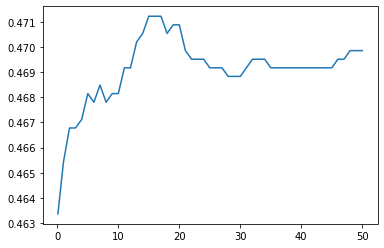

In [40]:
# Calcular coeficientes da logistic regression

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

candidates = {'query': queries_training,
              'doc': docs_training,
              'VSM_bt': VSM_bt_training,
              'VSM_dd': VSM_dd_training,
              'VSM_bs': VSM_bs_training,
              'VSM_cr': VSM_cr_training,
              'Y': y_training
              }
df = pd.DataFrame(candidates, columns=['query', 'doc',
                                       'VSM_bt', 'VSM_dd', 'VSM_bs', 'VSM_cr', 'Y'])
print(df)

x = df[['VSM_bt', 'VSM_dd', 'VSM_bs', 'VSM_cr']]
y = df['Y']

# cross-validation for different values of C
c_values = [0.1, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14,
            15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50]
c_ap = []
k = 5
kf = KFold(n_splits=k, random_state=None)

for c in c_values:
    print(c)
    acc_score = []
    for train_index, test_index in kf.split(x):
        X_train, X_test = x.iloc[train_index, :], x.iloc[test_index, :]
        y_train, y_test = y[train_index], y[test_index]
        clf = LogisticRegression(
            random_state=0, C=c, class_weight='balanced').fit(X_train, y_train)
        pred_values = clf.predict(X_test)

        acc = accuracy_score(pred_values, y_test)
        acc_score.append(acc)
    avg_acc_score = sum(acc_score)/k
    print('accuracy of each fold - {}'.format(acc_score))
    print('Avg accuracy : {}'.format(avg_acc_score))
    c_ap.append(avg_acc_score)


coefs = clf.coef_[0]
print('Coefs: {}'.format(coefs))

plt.plot(c_values, c_ap)


In [41]:
clf = LogisticRegression(
    random_state=0, C=18, class_weight='balanced').fit(x, y)
coefs = clf.coef_[0]
print('Coefs: {}'.format(coefs))


Coefs: [ 0.47022233 -1.8152483  -1.58591144 -2.40019506]


In [44]:
#scores para as queries de teste

p10_list=[]
recall_list=[]
ap_list=[]
ndcg5_list=[]
mrr_list=[]

avg_precision_11point = np.zeros(11)

for caseid in cases_test:
    VSM_bt_test = []
    VSM_dd_test = []
    VSM_bs_test = []
    VSM_cr_test = []
    """
    LMJM_bt_test = []
    LMJM_dd_test = []
    LMJM_bs_test = []
    LMJM_cr_test = []
    """
    y_test = []
    case_rel = []
    field_ind = 0
    zs = []
    aux = eval.relevance_judgments.loc[eval.relevance_judgments['query_id'] == int(
        caseid)]
    docs = aux['docid'].tolist()
    # print(len(docs))
    relevances = aux['rel'].tolist()
    for rel in relevances:
        if rel == 0:
            y_test.append(rel)
        elif rel == 1 or rel == 2:
            y_test.append(1)
    # print(len(relevances))
    for docid in docs:
        case_rel.append(ids.index(docid))
    # print(len(case_rel))
    for model in models:
        for field in fields:
            scores = model.search(caseid, field)
            for rel in case_rel:
                value = scores[rel]
                if field_ind == 0:
                    VSM_bt_test.append(value[0])
                elif field_ind == 1:
                    VSM_dd_test.append(value[0])
                elif field_ind == 2:
                    VSM_bs_test.append(value[0])
                elif field_ind == 3:
                    VSM_cr_test.append(value[0])
                """
                elif field_ind == 4:
                    LMJM_bt_test.append(value[0])
                elif field_ind == 5:
                    LMJM_dd_test.append(value[0])
                elif field_ind == 6:
                    LMJM_bs_test.append(value[0])
                elif field_ind == 7:
                    LMJM_cr_test.append(value[0])
                """
            field_ind += 1
    for line in range(0, len(VSM_bt_test)):
        #print(coefs[0] * VSM_bt_test[line] + coefs[1] * VSM_dd_test[line] + coefs[2] * VSM_bs_test[line] + coefs[3] * VSM_cr_test[line])
        z = coefs[0]*VSM_bt_test[line]+coefs[1]*VSM_dd_test[line] + coefs[2]*VSM_bs_test[line]+coefs[3]*VSM_cr_test[line]
        zs.append(z)

    doc_ids=[]
    for pos in case_rel:
        doc_ids.append(ids[pos])

    cand={'_id': doc_ids, 'score': zs}
    results = pd.DataFrame(cand, columns = ['_id', 'score'])
    
    candidates = {'query': caseid,
                  'doc': case_rel,
                  'VSM_bt': VSM_bt_test,
                  'VSM_dd': VSM_dd_test,
                  'VSM_bs': VSM_bs_test,
                  'VSM_cr': VSM_cr_test,
                  'Z': zs,
                  'Y': y_test
                  }
    df = pd.DataFrame(candidates, columns=['query', 'doc',
                                           'VSM_bt', 'VSM_dd', 'VSM_bs', 'VSM_cr', 'Z', 'Y'])

    df.sort_values(by=['Z'], inplace=True, ascending=True)

    [p10, recall, ap, ndcg5, mrr] = eval.eval(results, caseid)
    [precision_11point, recall_11point,
        total_relv_ret] = eval.evalPR(results, caseid)

    p10_list += [p10]
    recall_list += [recall]
    ap_list += [ap]
    ndcg5_list += [ndcg5]
    mrr_list += [mrr]


    print(df.head(10))
    #print("--------------------------------------------------------------------------------")
print(np.mean(p10_list))
print(np.mean(recall_list))
print(np.mean(ap_list))
print(np.mean(ndcg5_list))
print(np.mean(mrr_list))

    query   doc    VSM_bt    VSM_dd    VSM_bs    VSM_cr         Z  Y
0   20141     2  0.229724  0.118781  0.175044  0.246336 -0.976455  0
80  20141  1752  0.233912  0.010381  0.202823  0.230911 -0.784744  0
46  20141  1076  0.223839  0.000000  0.130805  0.246912 -0.694827  0
64  20141  1393  0.126810  0.024301  0.089507  0.235433 -0.691519  0
59  20141  1322  0.248736  0.034233  0.134311  0.186086 -0.604827  0
28  20141   592  0.158566  0.024421  0.182933  0.138963 -0.593424  1
34  20141   712  0.136239  0.046709  0.151178  0.135734 -0.586269  0
99  20141  2184  0.293626  0.044447  0.068155  0.222143 -0.583887  0
16  20141   295  0.033677  0.041373  0.019820  0.195614 -0.560211  1
61  20141  1345  0.047837  0.034185  0.005860  0.184953 -0.492776  1
    query   doc    VSM_bt    VSM_dd    VSM_bs    VSM_cr         Z  Y
23  20142   782  0.021487  0.044167  0.014762  0.140437 -0.430558  0
49  20142  2294  0.118906  0.010305  0.117239  0.110918 -0.414950  0
22  20142   775  0.013776  0.01235

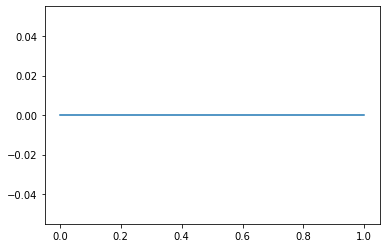

In [24]:

import matplotlib.pyplot as plt
plt.plot(recall_11point,avg_precision_11point/len(cases))